In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn import preprocessing
from sklearn.metrics import classification_report, accuracy_score
from src.model_selection import test_model
from sklearn.metrics import confusion_matrix, mean_squared_error
from scipy.stats import pearsonr

In [2]:
from src.processing import import_data
from src.model_selection import test_model
from src.metrics import equalized_odds
from src.visualizations import get_significant_correlations

# Load data

In [3]:
data_init, data_full, data, data_protected, data_y = import_data()

In [4]:
IsBlack = data_full.IsBlack == 1

In [5]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
index_cols = ["IsBlack"]

# DesicionTreeClassifier
## Baseline model

In [6]:
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)


model = DecisionTreeClassifier
model_params = {"max_depth":3, "random_state":1}

preds = test_model(model, X, y, kfold, model_params=model_params)

### Equalized odds regarding black ratio

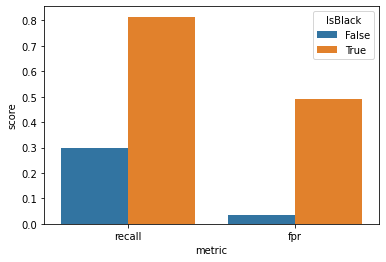

In [8]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
tmp_df = pd.concat([tmp_df_1, tmp_df_2])

sns.barplot(data=tmp_df, x="metric", y="score", hue="IsBlack")
plt.show()

In [9]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1620
           1       0.67      0.57      0.61       374

    accuracy                           0.87      1994
   macro avg       0.79      0.75      0.77      1994
weighted avg       0.86      0.87      0.86      1994



In [10]:
accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])

0.7026143790849673

In [11]:
accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])

0.8951421800947867

In [12]:
np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])

(194, 213.0)

In [13]:
np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])

(180, 105.0)

## Debias data baseline (desicion tree)

In [14]:
from src.debias_data import debias_data

In [15]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
protected_cols = ["racepctblack",
                      "racePctWhite", "racePctAsian", "racePctHisp"]
index_cols = ["IsBlack"]
nonprotected_cols = [col for col in data_full.columns if col not in protected_cols + y_cols + index_cols]

In [16]:
# Initialize X (with out the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [17]:
# Initialize the scaling and debiasing function
l_value = 0.0
scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)

In [18]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

model = DecisionTreeClassifier
model_params = {"random_state":1}

preds = test_model(model, X, y, kfold,scaler=scaler, model_params=model_params)

### Equalized odds regarding black ratio with unbias data

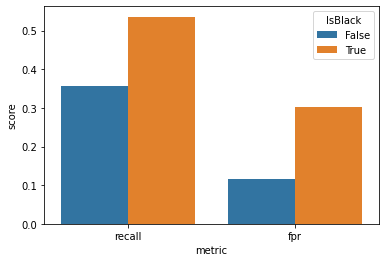

In [19]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
tmp_df = pd.concat([tmp_df_1, tmp_df_2])

sns.barplot(data=tmp_df, x="metric", y="score", hue="IsBlack")
plt.show()

In [20]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1620
           1       0.45      0.45      0.45       374

    accuracy                           0.79      1994
   macro avg       0.66      0.66      0.66      1994
weighted avg       0.79      0.79      0.79      1994



In [21]:
accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])

0.5947712418300654

In [22]:
accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])

0.8281990521327014

In [23]:
np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])

(194, 138.0)

In [24]:
np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])

(180, 238.0)

# Correlations

In [62]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
protected_cols = ["racepctblack",
                      "racePctWhite", "racePctAsian", "racePctHisp"]

In [59]:
tmp_df = X.copy()
tmp_df[y_cols] = data_y.copy()

<AxesSubplot:>

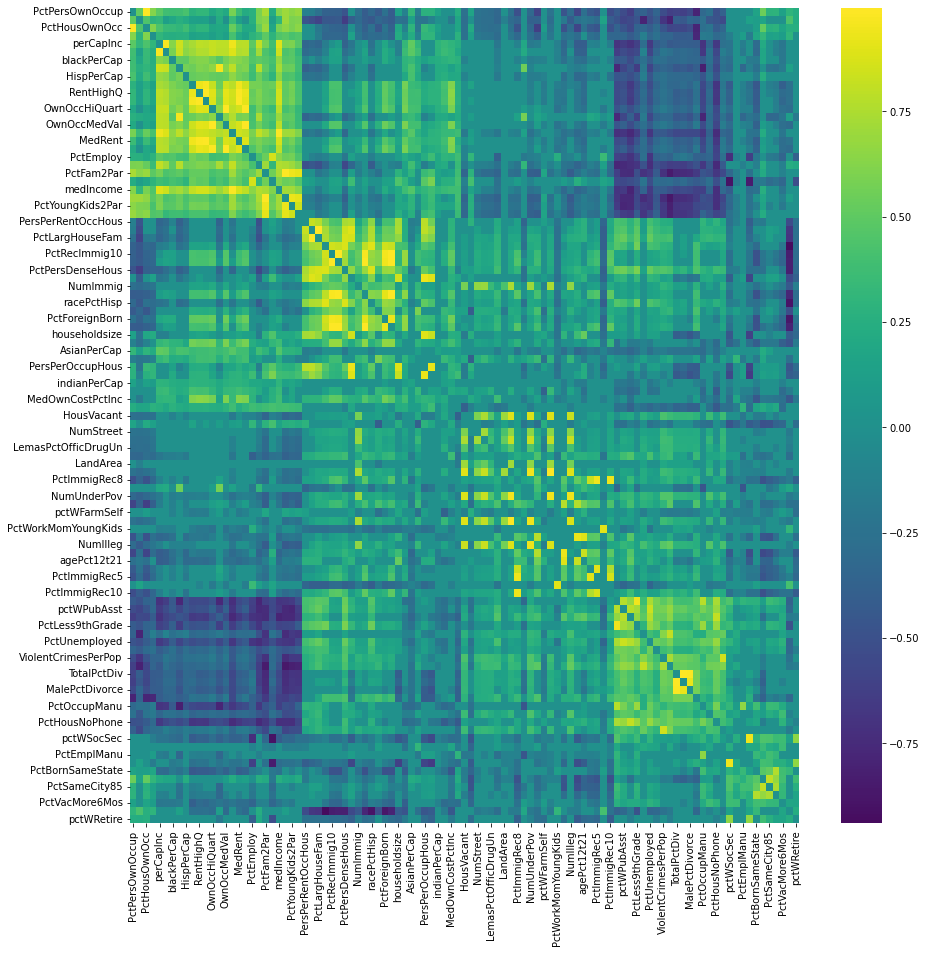

In [60]:
fig, ax = plt.subplots(1, figsize=(15,15))
sns.heatmap(get_significant_correlations(tmp_df), center=0, annot=False, cmap="viridis")

In [61]:
tmp_df[y_cols] = data_y

<AxesSubplot:>

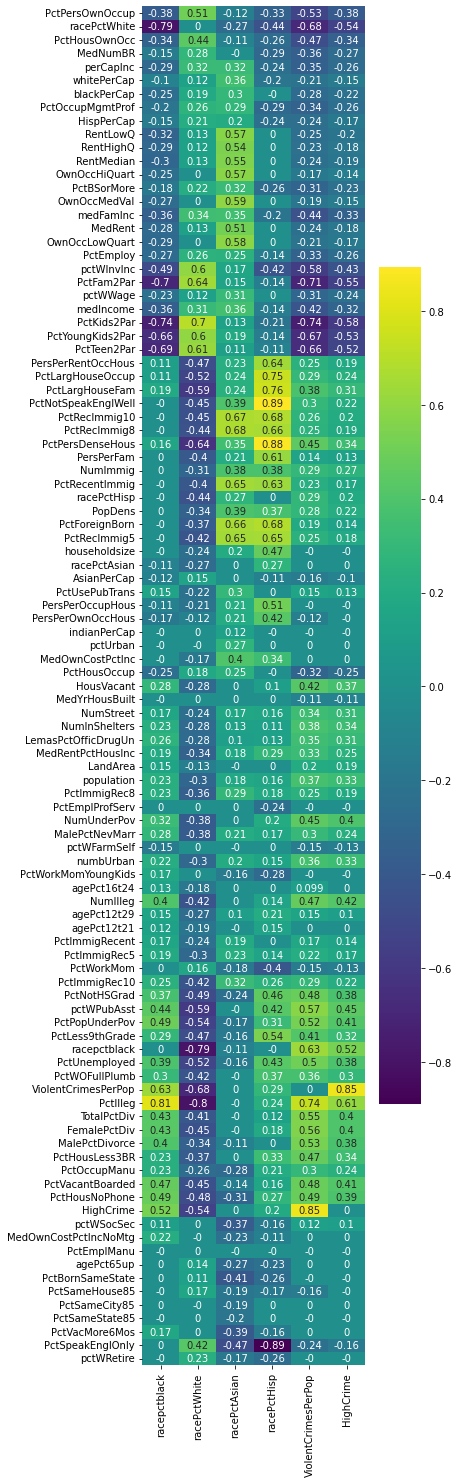

In [64]:
fig, ax = plt.subplots(1, figsize=(5,25))
sns.heatmap(get_significant_correlations(tmp_df)[protected_cols + y_cols], center=0, annot=True, cmap="viridis")

## Debiased corrs

In [27]:

index_cols = ["IsBlack"]
nonprotected_cols = [col for col in data_full.columns if col not in protected_cols + y_cols + index_cols]


In [28]:
tmp_df = data_full.copy().drop(columns=y_cols)
tmp_df, _ = debias_data(protected_cols, nonprotected_cols)(tmp_df, tmp_df)

In [29]:
tmp_df = pd.DataFrame(tmp_df, columns=nonprotected_cols)
tmp_df[y_cols] = data_y
tmp_df[protected_cols] = data_full[protected_cols]

<AxesSubplot:>

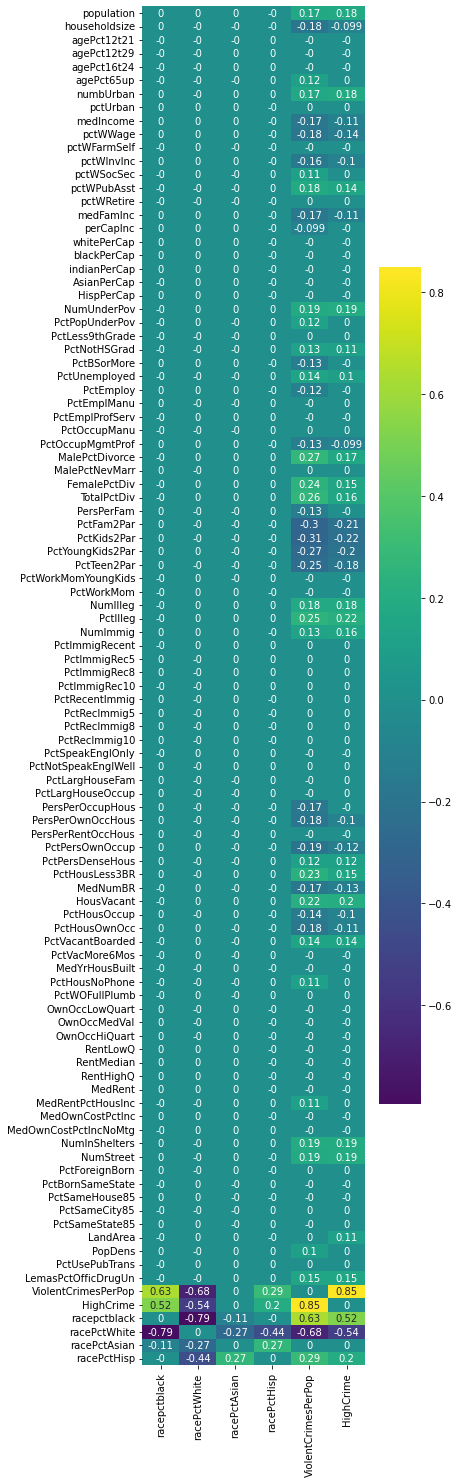

In [58]:
fig, ax = plt.subplots(1, figsize=(5,25))
sns.heatmap(get_significant_correlations(tmp_df, cluster=False)[protected_cols + y_cols], center=0, annot=True, cmap="viridis")

In [37]:
speaman_corr = get_significant_correlations(tmp_df, cluster=False, method="spearman")

<AxesSubplot:>

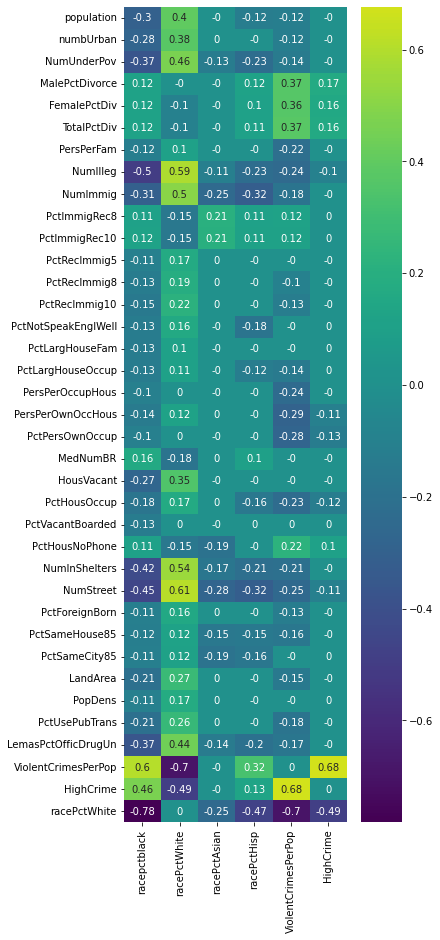

In [45]:
fig, ax = plt.subplots(1, figsize=(5,15))
sns.heatmap(speaman_corr[protected_cols + y_cols].loc[speaman_corr.racepctblack != 0,:], center=0, annot=True, cmap="viridis")

In [53]:
tmp_data = data_full.copy()
tmp_data[y_cols] = data_y
speaman_corr = get_significant_correlations(tmp_data, cluster=False, method="spearman")

<AxesSubplot:>

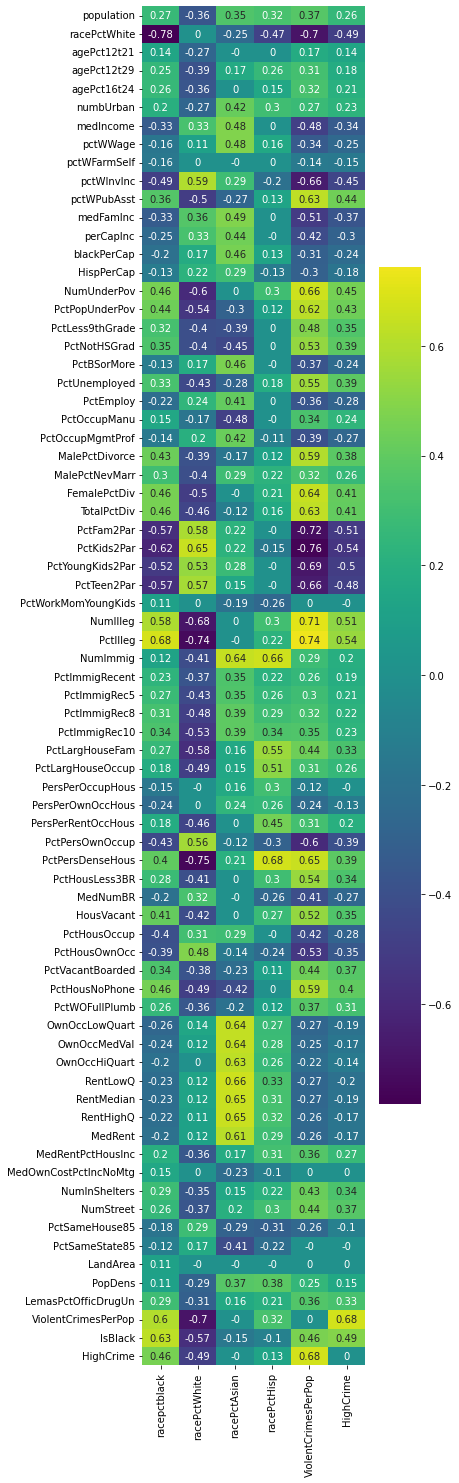

In [55]:
fig, ax = plt.subplots(1, figsize=(5,25))
sns.heatmap(speaman_corr[protected_cols + y_cols].loc[speaman_corr.racepctblack != 0,:], center=0, annot=True, cmap="viridis")